**L081_customer_segmentation.ipynb**

2024 JUN 12

Tershire

In [29]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# data

In [4]:
retail_df = pd.read_excel(io="../data/online_retail.xlsx")
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


## analysis

In [5]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [10]:
retail_df["Country"].value_counts()[:7]

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Name: count, dtype: int64

## preprocessing

### remove invalid data, deal with nulls

In [7]:
retail_df = retail_df[retail_df["Quantity"] > 0]
retail_df = retail_df[retail_df["UnitPrice"] > 0]
retail_df = retail_df[retail_df["CustomerID"].notnull()]

In [8]:
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### take only UK data

In [15]:
print(len(retail_df["Country"] == "United Kingdom"))

354321


In [11]:
retail_df = retail_df[retail_df["Country"] == "United Kingdom"]

In [12]:
print(retail_df.shape)

(354321, 8)


## preprocessing for RFM

In [16]:
retail_df["CustomerID"] = retail_df["CustomerID"].astype(int)
retail_df["sales"] = retail_df["Quantity"] * retail_df["UnitPrice"]

In [18]:
# purchase times
print(retail_df["CustomerID"].value_counts().head(5))

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64


In [21]:
# sales [euros]
print(retail_df.groupby("CustomerID")["sales"].sum().sort_values(ascending=False))

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
           ...    
16878        13.30
17956        12.75
16454         6.90
14792         6.20
16738         3.75
Name: sales, Length: 3920, dtype: float64


In [22]:
# (!) hard to understand
print(retail_df.groupby(["InvoiceNo", "StockCode"])["InvoiceNo"].count().mean())

1.028702077315023


### in the perspective of the customer

In [25]:
# make a new dataframe
aggregations= {
    "InvoiceDate": "max",
    "InvoiceNo": "count",
    "sales": "sum"}

customer_df = retail_df.groupby("CustomerID").agg(aggregations)

# change column names
customer_df = customer_df.rename(columns={"InvoiceDate": "Recency",
                                          "InvoiceNo": "Frequency",
                                          "sales": "Monetary"})

customer_df = customer_df.reset_index()

In [26]:
display(customer_df.head(3))

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


### convert recency to int representation

In [27]:
# assume we do this analysis on the next day of the latest sale
customer_df["Recency"].max()

Timestamp('2011-12-09 12:49:00')

In [30]:
import datetime as dt

In [31]:
customer_df["Recency"] = dt.datetime(2011, 12, 10) - customer_df["Recency"]
customer_df["Recency"] = customer_df["Recency"].apply(lambda x: x.days + 1)  # (?)

In [32]:
print("customer_df.shape", customer_df.shape)
display(customer_df.head(3))

customer_df.shape (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


## analysis

### histograms for RFM

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

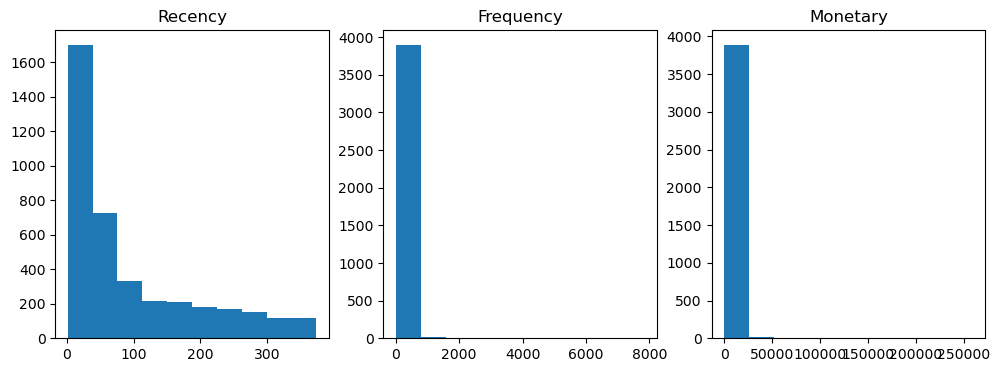

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax1.set_title("Recency")
ax1.hist(customer_df["Recency"])

ax2.set_title("Frequency")
ax2.hist(customer_df["Frequency"])

ax3.set_title("Monetary")
ax3.hist(customer_df["Monetary"])

In [34]:
customer_df[["Recency", "Frequency", "Monetary"]].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


# preprocessing for model

In [38]:
X = customer_df[["Recency", "Frequency", "Monetary"]].values

## scaling

In [37]:
from sklearn.preprocessing import StandardScaler

In [39]:
X_scaled = StandardScaler().fit_transform(X)

# model

In [35]:
from sklearn.cluster import KMeans

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0)

# training

In [42]:
cluster_ids = kmeans.fit_predict(X_scaled)

# evaluation

In [44]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [43]:
customer_df["cluster_id"] = cluster_ids

In [46]:
score = silhouette_score(X_scaled, cluster_ids)
print(f"silhouette score: {score:.3F}")

silhouette score: 0.576


## visualization

In [54]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [55]:
def visualize_silhouettes(Clusterer, num_clusterss, X):
    fig, axs = plt.subplots(figsize=(4*len(num_clusterss), 4), nrows=1, ncols=len(num_clusterss))

    cluster_coeff_meanss = []
    for i, num_clusters in enumerate(num_clusterss):
        # training
        clusterer = Clusterer(n_clusters=num_clusters, max_iter=500, random_state=0)
        cluster_ids = clusterer.fit_predict(X)

        # evaluation
        coeffs = silhouette_samples(X, cluster_ids)
        score = silhouette_score(X, cluster_ids)

        y_lower = 10
        cluster_coeff_means = []
        for j in range(num_clusters):
            cluster_coeffs = coeffs[cluster_ids == j]
            cluster_coeff_means.append(np.mean(cluster_coeffs))
            
            cluster_coeffs.sort()

            cluster_num_samples = cluster_coeffs.shape[0]
            y_upper = y_lower + cluster_num_samples
            
            color = cm.nipy_spectral(float(j) / num_clusters)
            axs[i].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_coeffs,
                                facecolor=color, edgecolor=color, alpha=0.75)
            axs[i].text(-0.05, y_lower + 0.5 * cluster_num_samples, str(j))
            y_lower = y_upper + 10

        axs[i].axvline(x=score, color="red", linestyle="--")

        axs[i].set_title("Number of Clusters: " + str(num_clusters) + '\n' \
                        "Silhouette Score: " + str(np.round(score, 3)))
        axs[i].set_xlabel("Silhouette Coefficients")
        axs[i].set_ylabel("Cluster ID")
        axs[i].set_xlim([-0.1, 1])
        axs[i].set_ylim([0, len(X) + (num_clusters + 1) * 10])
        axs[i].set_xticks(np.linspace(0, 1, 6))
        axs[i].set_yticks([])  # clear

        cluster_coeff_meanss.append(cluster_coeff_means)

    # print cluster standard deviations
    for i, cluster_coeff_means in enumerate(cluster_coeff_meanss):
        print(f"case of {num_clusterss[i]} clusters:")
        print(f"mean sihouette coefficient for each cluster: {np.round(cluster_coeff_meanss[i], 3)}")
        print(f"mean sihouette coefficient standard deviation: {np.round(np.std(cluster_coeff_meanss[i]), 3)}")

In [56]:
def visualize_clustering(Clusterer, num_clusterss, X):
    fig, axs = plt.subplots(figsize=(4*len(num_clusterss), 4), nrows=1, ncols=len(num_clusterss), tight_layout=True)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    for i, num_clusters in enumerate(num_clusterss):
        # training
        clusterer = Clusterer(n_clusters=num_clusters, max_iter=500, random_state=0)
        cluster_ids = clusterer.fit_predict(X_pca)

        cluster_centers = clusterer.cluster_centers_
        axs[i].scatter(x=X_pca[:, 0], y=X_pca[:, 1], edgecolors='k', c=cluster_ids)
        
        for j, cluster_center in enumerate(cluster_centers):
            # shape
            axs[i].scatter(x=cluster_center[0], y=cluster_center[1],
                        s=200, color="white", alpha=0.75,
                        edgecolors='k', marker='o')
            # text
            axs[i].scatter(x=cluster_center[0], y=cluster_center[1],
                        s=70, color='k',
                        edgecolors='k', marker="$%d$" % j)

        axs[i].set_xlabel("PCA feature 1")
        axs[i].set_ylabel("PCA feature 2")

case of 2 clusters:
mean sihouette coefficient for each cluster: [0.947 0.697]
mean sihouette coefficient standard deviation: 0.125
case of 3 clusters:
mean sihouette coefficient for each cluster: [0.596 0.696 0.569]
mean sihouette coefficient standard deviation: 0.055
case of 4 clusters:
mean sihouette coefficient for each cluster: [0.592 0.696 0.582 0.593]
mean sihouette coefficient standard deviation: 0.047
case of 5 clusters:
mean sihouette coefficient for each cluster: [0.584 0.678 0.05  0.554 0.662]
mean sihouette coefficient standard deviation: 0.232


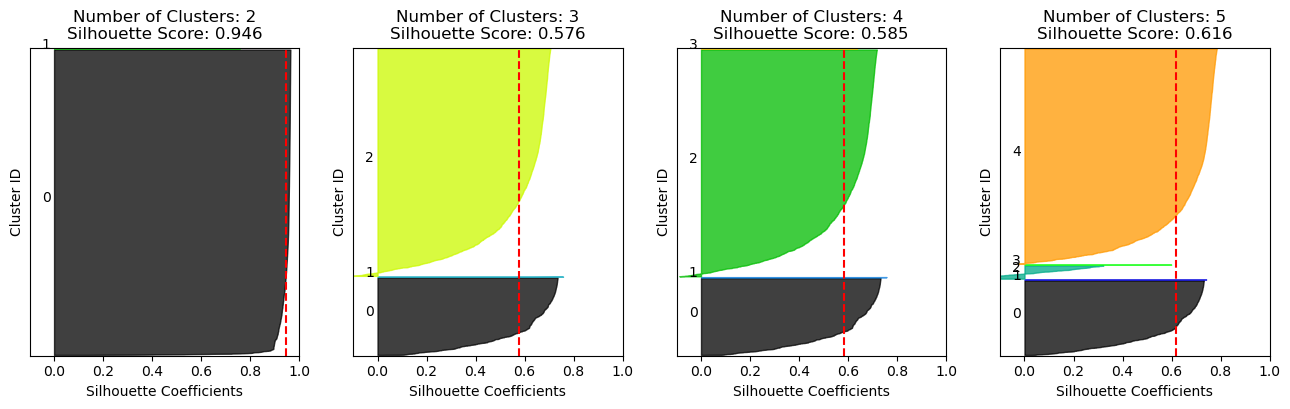

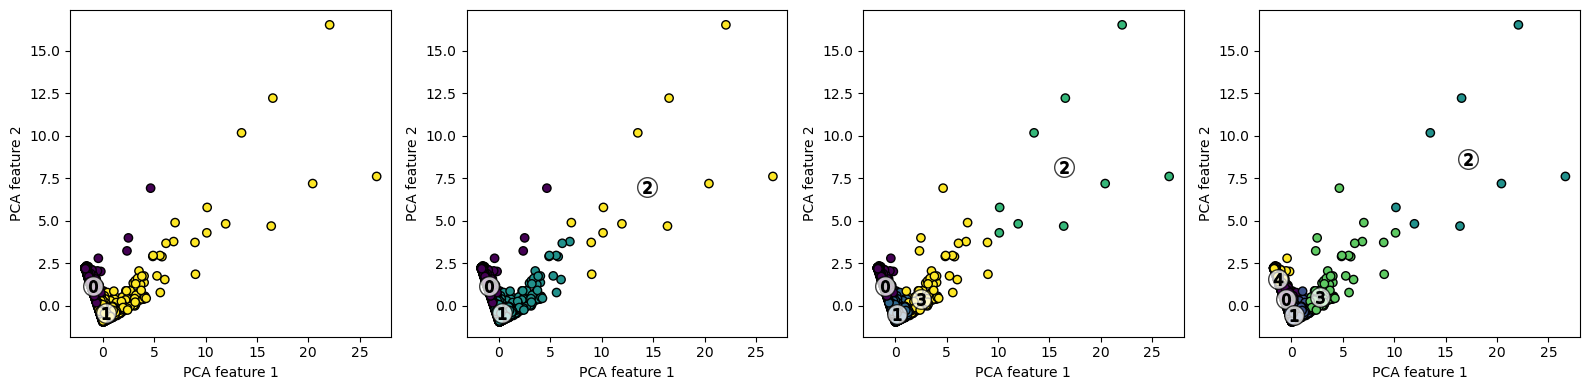

In [57]:
num_clusterss = np.arange(2, 6)
visualize_silhouettes(KMeans, num_clusterss, X_scaled)
visualize_clustering(KMeans, num_clusterss, X_scaled)

# re-preprocessing

## log-scaling

In [58]:
customer_df["log_Recency"] = np.log1p(customer_df["Recency"])
customer_df["log_Frequency"] = np.log1p(customer_df["Frequency"])
customer_df["log_Monetary"] = np.log1p(customer_df["Monetary"])

In [59]:
X = customer_df[["log_Recency", "log_Frequency", "log_Monetary"]].values

## scaling

In [60]:
X_scaled = StandardScaler().fit_transform(X)

# model

In [61]:
kmeans = KMeans(n_clusters=3, random_state=0)

# training

In [62]:
cluster_ids = kmeans.fit_predict(X_scaled)

# evaluation

In [65]:
customer_df["cluster_id"] = cluster_ids

In [66]:
score = silhouette_score(X_scaled, cluster_ids)
print(f"silhouette score: {score:.3F}")

silhouette score: 0.303


## visualization

case of 2 clusters:
mean sihouette coefficient for each cluster: [0.415 0.381]
mean sihouette coefficient standard deviation: 0.017
case of 3 clusters:
mean sihouette coefficient for each cluster: [0.345 0.32  0.259]
mean sihouette coefficient standard deviation: 0.036
case of 4 clusters:
mean sihouette coefficient for each cluster: [0.358 0.299 0.234 0.313]
mean sihouette coefficient standard deviation: 0.044
case of 5 clusters:
mean sihouette coefficient for each cluster: [0.306 0.295 0.234 0.284 0.251]
mean sihouette coefficient standard deviation: 0.027


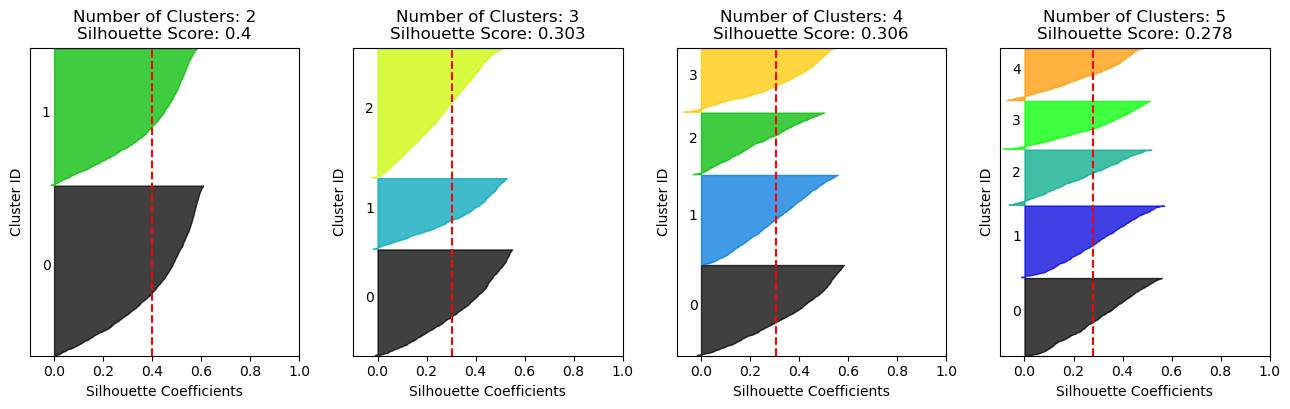

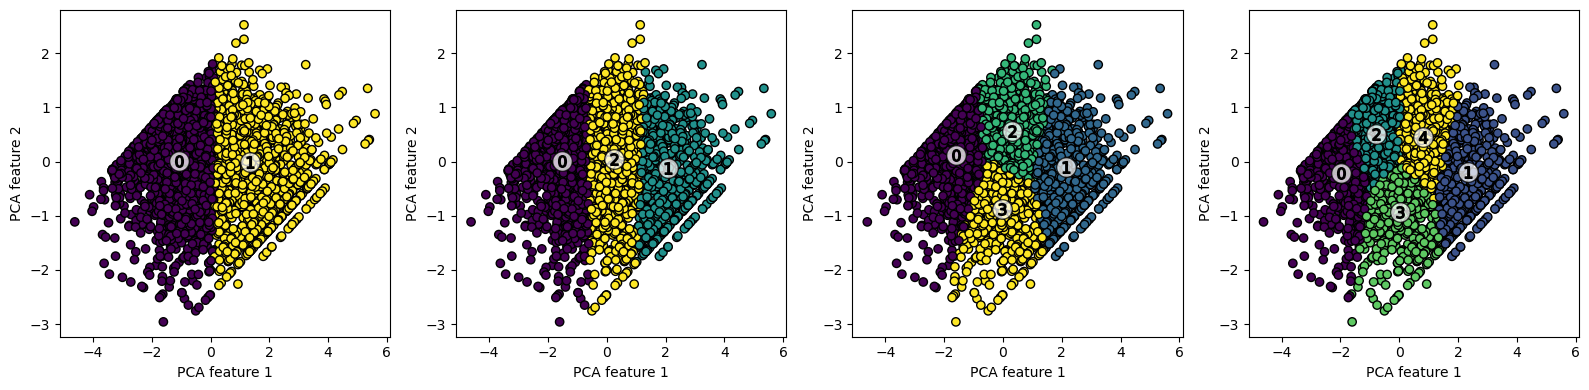

In [67]:
num_clusterss = np.arange(2, 6)
visualize_silhouettes(KMeans, num_clusterss, X_scaled)
visualize_clustering(KMeans, num_clusterss, X_scaled)